**Library**

In [ ]:
!pip install emoji
!pip install Sastrawi
!pip install umap-learn
!pip install simplemma
!pip install fasttext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4296185 sha256=b64f9332164c7cdfde0214b741a3fdc3739b4829dccc316bf6651fcb4f3cefd1
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3

In [ ]:
import string
import re
import emoji
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
import umap
import simplemma
import fasttext
from collections import Counter
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
warnings.filterwarnings('ignore')
sns.set(style='white', palette='muted', color_codes=True)

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Text Pre-Processing

In [ ]:
df = pd.read_csv('/content/Scrapping-HOK.csv')
df.head()

content  score    Label
0  Emang sampah sistem game loe Tencent t43k koto...      1  Negatif
1  Saya sudah memainkan honor of Kings lebih dari...      1  Negatif
2  Maching ngga seimbang , tiap main ranked selal...      1  Negatif
3  tolong lah di perbaiki buat hero sesuai karakt...      1  Negatif
4  gamenya overal udah bagus sih,cuman yang harus...      1  Negatif

**Case Folding**

In [ ]:
def casefolding(content):
  content = content.lower()
  return content

df['content'] = df['content'].apply(lambda x: casefolding(x))

**Cleaning**

In [ ]:
def cleaning(content):
  content = content.strip(' ')
  content = re.sub(r'\d+', '', content)
  content = content.translate(str.maketrans('','', string.punctuation))
  content = re.sub(r'\b[a-zA-Z]\b', '', content)
  content = re.sub(r'\s+', ' ', content)
  return content

df['content'] = df['content'].apply(lambda x: cleaning(x))

**Emoji/Emoticon Removal**

In [ ]:
def emoji_removal(content):
  content = emoji.replace_emoji(content, replace='')
  return content

df['content'] = df['content'].apply(lambda x: emoji_removal(x))

In [ ]:
def remove_emoticons(content):
    emoticon_pattern = re.compile(r"""
        (?::|;|=) # Kolom, titik koma, atau tanda sama dengan untuk wajah
        (?:-)? # Tanda minus opsional
        (?:\)|\(|D|P|O|/|\|S) # char yang menunjukkan ekspresi
        """, re.VERBOSE)

    return emoticon_pattern.sub(r'', content)

df['content'] = df['content'].apply(lambda x: remove_emoticons(x))

**Spell Checker (Spelling Correction, Slang Words, Chat Words)**

In [ ]:
spellchecker_dict = pd.read_csv('/content/spellcheck_dict_hok.csv')
spellchecker_dict.dropna(subset=['replacement'], inplace=True)
spellchecker_dict = dict(zip(spellchecker_dict['term'], spellchecker_dict['replacement']))

def spellcheck_text(text, spellchecker_dict):
    words = text.split()
    corrected_words = [spellchecker_dict.get(word, word) for word in words]
    return ' '.join(corrected_words)

df['content'] = df['content'].apply(lambda x: spellcheck_text(x, spellchecker_dict))

**Tokenization**

In [ ]:
def tokenisasi(content):
  content = word_tokenize(content)
  return content

df['textToken'] = df['content'].apply(lambda x: tokenisasi(x))

In [ ]:
df.head()

content  score    Label  \
0  memang sampah sistem game kamu tencent tk koto...      1  Negatif   
1  saya sudah memainkan honor of kings lebih dari...      1  Negatif   
2  matching tidak imbang tiap main ranked selalu ...      1  Negatif   
3  tolong lah di baik buat hero sesuai karakter l...      1  Negatif   
4  game semua sudah bagus cuma yang harus di atur...      1  Negatif   

                                           textToken  
0  [memang, sampah, sistem, game, kamu, tencent, ...  
1  [saya, sudah, memainkan, honor, of, kings, leb...  
2  [matching, tidak, imbang, tiap, main, ranked, ...  
3  [tolong, lah, di, baik, buat, hero, sesuai, ka...  
4  [game, semua, sudah, bagus, cuma, yang, harus,...

**Lemmatization**

In [ ]:
def lemmatisasi(content):
  return [simplemma.lemmatize(word, lang='id') for word in content]

df['textLemma'] = df['textToken'].apply(lambda x: lemmatisasi(x))

**Stopwords Removal**

In [ ]:
factory = StopWordRemoverFactory()
sastrawi_stopwords = factory.get_stop_words()

nltk_stopword = stopwords.words('indonesian')

combine_stopwords = set(sastrawi_stopwords + nltk_stopword)

def stopwords(content):
  content = [word for word in content if word not in combine_stopwords]
  return content

df['textSWR'] = df['textLemma'].apply(lambda x: stopwords(x))

**Stemming**

In [ ]:
!pip install Sastrawi

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
def stemmed_wrapper(term):
  return stemmer.stem(term)

term_dict = {}
hitung = 0

for document in df['textSWR']:
  for term in document:
    if term not in term_dict:
      term_dict[term] = ' '

for term in term_dict:
  term_dict[term] = stemmed_wrapper(term)
  hitung += 1

def get_stemmed_term(document):
  return [term_dict[term] for term in document]

df['textStemm'] = df['textSWR'].apply(lambda x: get_stemmed_term(x))

**Stopwords Removal Extended (After WordCloud)**

In [ ]:
cswr = set(STOPWORDS)
cswr.update(["game", "nya", "main", "hero", "match",
             "tim", "aja", "sistem", "banget", "udah",
             "kasih", "player", "update", "pas", "rank"])

def remove_cswr(word_list):
    return [word for word in word_list if word.lower() not in cswr]

df['textStemm'] = df['textStemm'].apply(remove_cswr)

In [ ]:
cswr_positif = set(STOPWORDS)
cswr_positif.update(["lag", "nya bagus", "bug"])

cswr_negatif = set(STOPWORDS)
cswr_negatif.update(["bagus", "baik", "suka"])

def remove_cswr(word_list, label):

    if label == 'Positif':
        custom_stopwords = cswr_positif
    elif label == 'Negatif':
        custom_stopwords = cswr_negatif

    return [word for word in word_list if word.lower() not in custom_stopwords]

df['textStemm'] = df.apply(lambda row: remove_cswr(row['textStemm'], row['Label']), axis=1)

In [ ]:
df['textStemmSTR'] = df['textStemm'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

In [ ]:
df.head()

content  score    Label  \
0  memang sampah sistem game kamu tencent tk koto...      1  Negatif   
1  saya sudah memainkan honor of kings lebih dari...      1  Negatif   
2  matching tidak imbang tiap main ranked selalu ...      1  Negatif   
3  tolong lah di baik buat hero sesuai karakter l...      1  Negatif   
4  game semua sudah bagus cuma yang harus di atur...      1  Negatif   

                                           textToken  \
0  [memang, sampah, sistem, game, kamu, tencent, ...   
1  [saya, sudah, memainkan, honor, of, kings, leb...   
2  [matching, tidak, imbang, tiap, main, ranked, ...   
3  [tolong, lah, di, baik, buat, hero, sesuai, ka...   
4  [game, semua, sudah, bagus, cuma, yang, harus,...   

                                           textLemma  \
0  [memang, sampah, sistem, game, kamu, tencent, ...   
1  [saya, sudah, main, honor, of, kings, lebih, d...   
2  [matching, tidak, imbang, tiap, main, ranked, ...   
3  [tolong, lah, di, baik, buat, hero, sesuai, ka...   
4  [game, semua, sudah, bagus, cuma, yang, harus,...   

                                             textSWR  \
0  [sampah, sistem, game, tencent, tk, kotor, iya...   
1  [main, honor, of, kings, tim, lawan, hebat, ti...   
2  [matching, imbang, main, ranked, tim, main, ak...   
3  [hero, sesuai, karakter, lane, hapus, mid, lan...   
4  [game, bagus, atur, tim, iya, tier, mythic, bu...   

                                           textStemm  \
0  [sampah, tencent, tk, kotor, iya, feeding, sen...   
1  [honor, kings, lawan, hebat, capek, lucu, hapu...   
2  [matching, imbang, ranked, akun, level, aneh, ...   
3  [sesuai, karakter, lane, hapus, mid, lane, pak...   
4               [atur, iya, tier, mythic, buta, map]   

                                        textStemmSTR  
0  sampah tencent tk kotor iya feeding sengaja ja...  
1  honor kings lawan hebat capek lucu hapus ngota...  
2  matching imbang ranked akun level aneh klasik ...  
3  sesuai karakter lane hapus mid lane pakai fram...  
4                      atur iya tier mythic buta map

# Feature Engineering

## TF-IDF

In [ ]:
tfidf = TfidfVectorizer(use_idf=True, smooth_idf=True, max_features=1500)

response = tfidf.fit_transform(df['textStemmSTR'])

data_IDF = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names_out())

In [ ]:
df['Label'] = df['Label'].replace({'Negatif': 0, 'Positif': 1})

## BOW

In [ ]:
bowvec = CountVectorizer()

response = bowvec.fit_transform(df['textStemmSTR'])

data_BOW = pd.DataFrame(response.toarray(), columns=bowvec.get_feature_names_out())

## w2vec

In [ ]:
w2vec = Word2Vec(
    sentences=df['textStemm'],
    vector_size=100,
    window=5,
    min_count=3,
    sg=0
)

w2vec.save('word2vec.model')

In [ ]:
model_w2vec = Word2Vec.load('word2vec.model')

In [ ]:
w2v = model_w2vec.wv
w2v.index_to_key[:10]

['bagus',
 'jaring',
 'download',
 'musuh',
 'bot',
 'skin',
 'data',
 'hok',
 'grafik',
 'bintang']

In [ ]:
X = umap.UMAP().fit_transform(w2v.vectors)

df2 = pd.DataFrame(X, columns=['umap1', 'umap2'])
df2['word'] = w2v.index_to_key

fig = px.scatter(df2, x='umap1', y='umap2', text='word')
fig.update_traces(textposition='top center')
fig.update_layout(height = 800,
                  title_text = 'Word2Vec Visualization')
fig.show()

## FastText

In [ ]:
data_FT = df['textStemmSTR']

In [ ]:
data_FT

0       sampah tencent tk kotor iya feeding sengaja ja...
1       honor kings lawan hebat capek lucu hapus ngota...
2       matching imbang ranked akun level aneh klasik ...
3       sesuai karakter lane hapus mid lane pakai fram...
4                           atur iya tier mythic buta map
                              ...                        
1738    segi susah musuh komentar musuh susah coba per...
1739    gimana min stuck loading gabisa login rilis se...
1740    turun grafik force close gara gara fps setting...
1741    lobi sinyal jelek dikit dikit muter nonton you...
1742    developer kali menang kalah imbang joystick se...
Name: textStemmSTR, Length: 1743, dtype: object

In [ ]:
data_FT.to_csv('data_FT.txt', index=False, header=False, sep=' ')

In [ ]:
model_FT = '/content/data_FT.txt'

In [ ]:
model = fasttext.train_supervised(model_FT, epoch=25, lr=1.0, wordNgrams=2, verbose=2, minCount=1)
model.save_model("fasttext_model.bin")

print("Fasttext Model trained and saved successfully!")

Fasttext Model trained and saved successfully!


In [ ]:
words = list(model.words)
word_vectors = np.array([model.get_word_vector(word) for word in words])

FastText (PCA)

In [ ]:
pca = PCA(n_components=2)

word_vector_2d = pca.fit_transform(word_vectors)

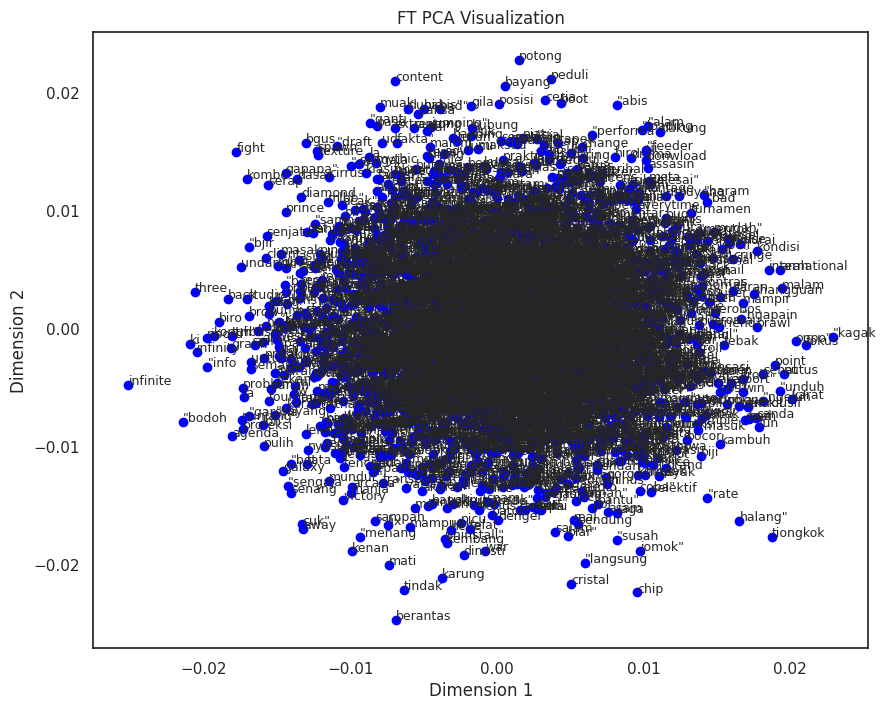

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(word_vector_2d[:, 0], word_vector_2d[:, 1], c='blue', label='Words')

for i, word in enumerate(words):
  plt.annotate(word, (word_vector_2d[i, 0], word_vector_2d[i, 1]), fontsize=9)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('FT PCA Visualization')
plt.show()

FastText (PCA) with KNN

In [ ]:
n_neighbors = 1

nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(word_vector_2d)
distances, indices = nearest_neighbors.kneighbors(word_vector_2d)

subset_size = 100
words_subset = words[:subset_size]
word_vector_subset = word_vector_2d[:subset_size]

fig = px.scatter(x=word_vector_subset[:, 0], y=word_vector_subset[:, 1], title='Visualisasi Kata-kata Pada Ulasan (ft. Fasttext PCA)')

annotations = []
for i, word in enumerate(words_subset):
    annotations.append(
        dict(
            x=word_vector_subset[i, 0],
            y=word_vector_subset[i, 1],
            text=word,
            showarrow=True,
            arrowhead=7,
            ax=20,
            ay=-30
        )
    )

lines = []
for i in range(subset_size):
    for neighbor_index in indices[i][1:]:
        lines.append(
            go.Scatter(
                x=[word_vector_subset[i, 0], word_vector_2d[neighbor_index, 0]],
                y=[word_vector_subset[i, 1], word_vector_2d[neighbor_index, 1]],
                mode="lines",
                line=dict(color="gray", width=1),
                showlegend=False
            )
        )

fig.update_layout(
    annotations=annotations,
    height=800,
    width=800,
    showlegend=False
)

for line in lines:
    fig.add_trace(line)

fig.show()

FastText (tSNE)

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
word_vector_2d_tsne = tsne.fit_transform(word_vectors)

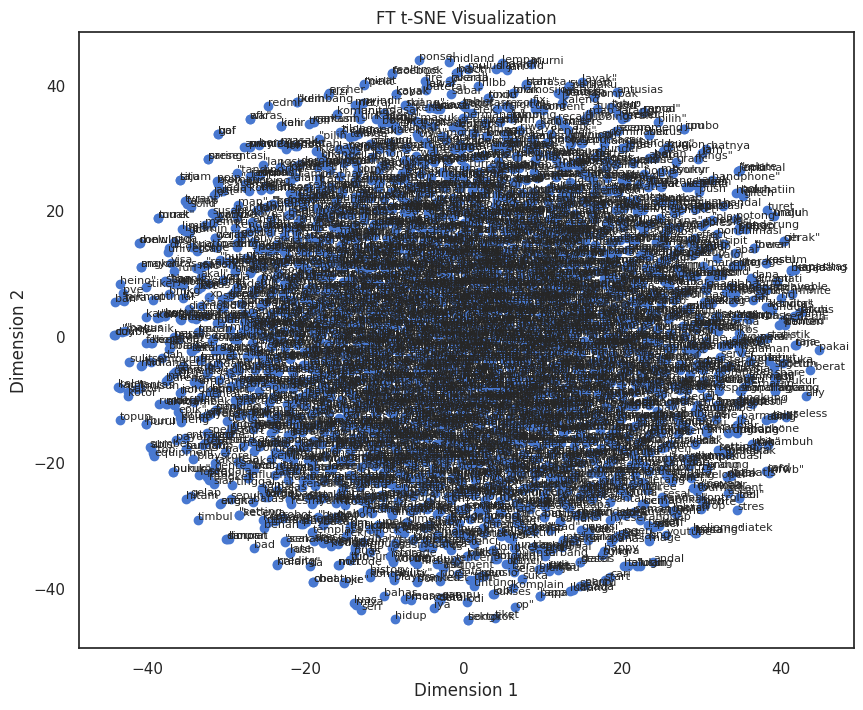

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(word_vector_2d_tsne[:, 0], word_vector_2d_tsne[:, 1], marker='o')

for i, word in enumerate(words):
    plt.annotate(word, (word_vector_2d_tsne[i, 0], word_vector_2d_tsne[i, 1]), fontsize=8)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('FT t-SNE Visualization')
plt.show()

FastText (tSNE) with KNN

In [ ]:
n_neighbors = 1

nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(word_vector_2d_tsne)
distances, indices = nearest_neighbors.kneighbors(word_vector_2d_tsne)

subset_size = 100
words_subset = words[:subset_size]
word_vector_subset = word_vector_2d_tsne[:subset_size]

fig = px.scatter(x=word_vector_subset[:, 0], y=word_vector_subset[:, 1], title='Visualisasi Kata-kata Pada Ulasan (ft. Fasttext t-SNE)')

annotations = []
for i, word in enumerate(words_subset):
    annotations.append(
        dict(
            x=word_vector_subset[i, 0],
            y=word_vector_subset[i, 1],
            text=word,
            showarrow=True,
            arrowhead=7,
            ax=20,
            ay=-30
        )
    )

lines = []
for i in range(subset_size):
    for neighbor_index in indices[i][1:]:
        lines.append(
            go.Scatter(
                x=[word_vector_subset[i, 0], word_vector_2d_tsne[neighbor_index, 0]],
                y=[word_vector_subset[i, 1], word_vector_2d_tsne[neighbor_index, 1]],
                mode="lines",
                line=dict(color="gray", width=1),
                showlegend=False
            )
        )

fig.update_layout(
    annotations=annotations,
    height=800,
    width=800,
    showlegend=False
)

for line in lines:
    fig.add_trace(line)

fig.show()

Check Similarity

In [ ]:
model = fasttext.load_model('fasttext_model.bin')
word = 'hok'

neighbors = model.get_nearest_neighbors(word, k=5)

print(f"Kata yang mirip dengan '{word}':")
for neighbor in neighbors:
    print(neighbor)

Kata yang mirip dengan 'hok':
(0.37654632329940796, 'galucu')
(0.35174551606178284, 'arcana"')
(0.34636563062667847, 'dolia"')
(0.34613439440727234, 'gokil')
(0.31289640069007874, 'fakta')


# UMAP

In [ ]:
reducer = umap.UMAP()
X_umap = reducer.fit_transform(response.toarray())

df['umap_1'] = X_umap[:, 0]
df['umap_2'] = X_umap[:, 1]

In [ ]:
flg = px.scatter(df, x='umap_1', y='umap_2', color='Label', title='UMAP Visualization', text='textStemm')
flg.update_layout(height=650)
flg.show()

# Insight

## Word Cloud

Overall

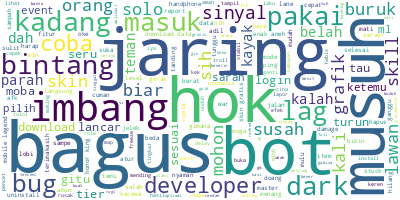

In [ ]:
long_string = ','.join(list(df['textStemmSTR'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

Positif (1), Negatif (0)



Label 0:


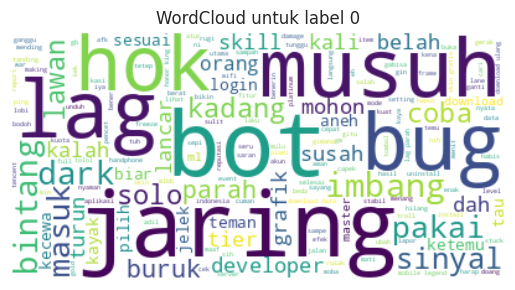


Label 1:


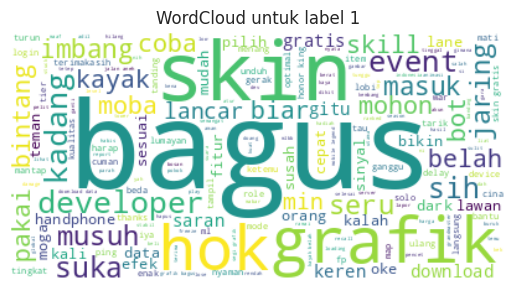

In [ ]:
for label in df['Label'].unique():
    text_data = " ".join(df[df['Label'] == label]['textStemmSTR'])

    wordcloud = WordCloud(
        background_color="white",
        max_words=5000,
        contour_width=3,
        contour_color='steelblue'
    ).generate(text_data)

    print(f"\nLabel {label}:")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud untuk label {label}")
    plt.show()

## Top 10 Words

Overall

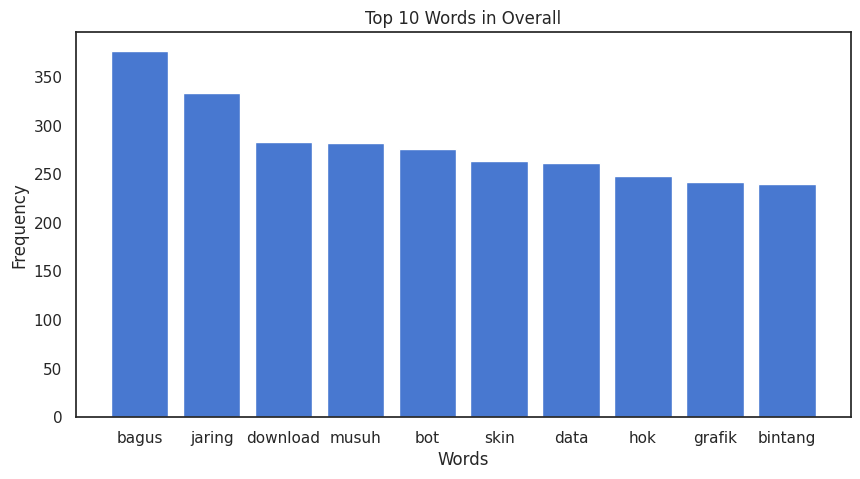

In [ ]:
top_words = Counter(" ".join(df['textStemmSTR']).split()).most_common(10)

words, counts = zip(*top_words)
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words in Overall')
plt.show()

Positif (1), Negatif (0)


label 0:


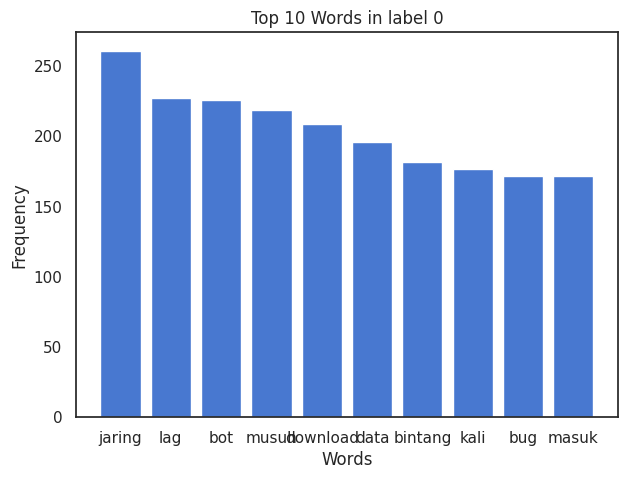


label 1:


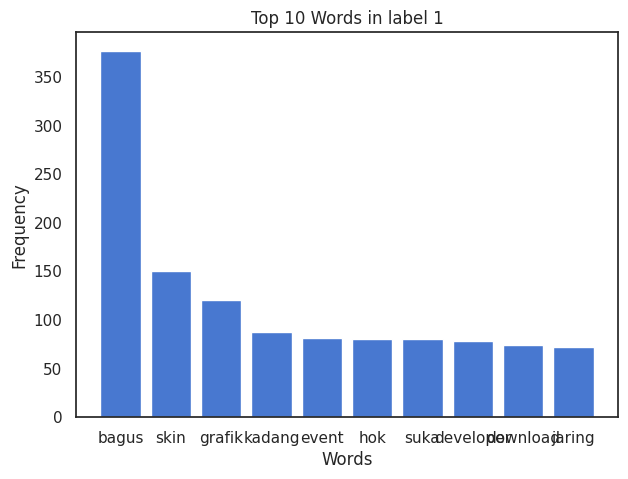

In [ ]:
for label in df['Label'].unique():

    text_data = " ".join(df[df['Label'] == label]['textStemmSTR'])

    top_words = Counter(text_data.split()).most_common(10)

    words, counts = zip(*top_words)

    print(f"\nlabel {label}:")
    plt.figure(figsize=(7, 5))
    plt.bar(words, counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Words in label {label}')
    plt.show()

In [ ]:
df['Label'] = df['Label'].replace({ 0 : 'Negatif', 1 : 'Positif'})

In [ ]:
df.to_csv('RAW-Preprocessing-HOK.csv', index=False)

# Modelling: Clustering Label Negatif

In [ ]:
df_neg = []

for index, row, in df.iterrows():
  if row['Label'] == 'Negatif':
    df_neg.append(row)

df_neg =  pd.DataFrame(df_neg)
df_neg = df_neg[:500]
df_neg.head()

content  score    Label  \
0  memang sampah sistem game kamu tencent tk koto...      1  Negatif   
1  saya sudah memainkan honor of kings lebih dari...      1  Negatif   
2  matching tidak imbang tiap main ranked selalu ...      1  Negatif   
3  tolong lah di baik buat hero sesuai karakter l...      1  Negatif   
4  game semua sudah bagus cuma yang harus di atur...      1  Negatif   

                                           textToken  \
0  [memang, sampah, sistem, game, kamu, tencent, ...   
1  [saya, sudah, memainkan, honor, of, kings, leb...   
2  [matching, tidak, imbang, tiap, main, ranked, ...   
3  [tolong, lah, di, baik, buat, hero, sesuai, ka...   
4  [game, semua, sudah, bagus, cuma, yang, harus,...   

                                           textLemma  \
0  [memang, sampah, sistem, game, kamu, tencent, ...   
1  [saya, sudah, main, honor, of, kings, lebih, d...   
2  [matching, tidak, imbang, tiap, main, ranked, ...   
3  [tolong, lah, di, baik, buat, hero, sesuai, ka...   
4  [game, semua, sudah, bagus, cuma, yang, harus,...   

                                             textSWR  \
0  [sampah, sistem, game, tencent, tk, kotor, iya...   
1  [main, honor, of, kings, tim, lawan, hebat, ti...   
2  [matching, imbang, main, ranked, tim, main, ak...   
3  [hero, sesuai, karakter, lane, hapus, mid, lan...   
4  [game, bagus, atur, tim, iya, tier, mythic, bu...   

                                           textStemm  \
0  [sampah, tencent, tk, kotor, iya, feeding, sen...   
1  [honor, kings, lawan, hebat, capek, lucu, hapu...   
2  [matching, imbang, ranked, akun, level, aneh, ...   
3  [sesuai, karakter, lane, hapus, mid, lane, pak...   
4               [atur, iya, tier, mythic, buta, map]   

                                        textStemmSTR    umap_1     umap_2  
0  sampah tencent tk kotor iya feeding sengaja ja...  8.789422  11.227035  
1  honor kings lawan hebat capek lucu hapus ngota...  8.118306  10.621984  
2  matching imbang ranked akun level aneh klasik ...  8.659476  10.360600  
3  sesuai karakter lane hapus mid lane pakai fram...  9.987400   8.413848  
4                      atur iya tier mythic buta map  8.148213   9.851102

In [ ]:
len(df_neg)

500

In [ ]:
tfidf = TfidfVectorizer(use_idf=True, smooth_idf=True, max_features=1500)

response = tfidf.fit_transform(df_neg['textStemmSTR'])

data_IDF_neg = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names_out())

## KMeans

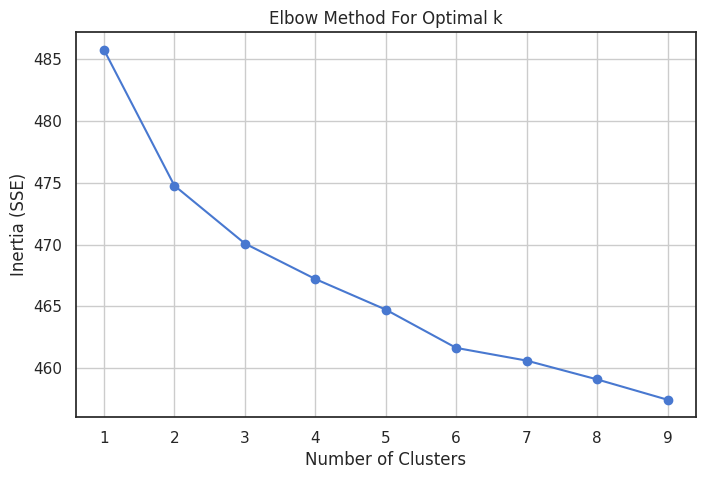

In [ ]:
inertia = []
cluster_range = range(1, 10)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_IDF_neg)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (SSE)')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [ ]:
num_clusters = 6

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_neg['Cluster_KMeans'] = kmeans.fit_predict(data_IDF_neg)

In [ ]:
silhouette_avg = silhouette_score(data_IDF_neg, df_neg['Cluster_KMeans'])
print(f"The average silhouette_score is : {silhouette_avg}")

The average silhouette_score is : 0.017571133944701365



Cluster (KMeans) 4:


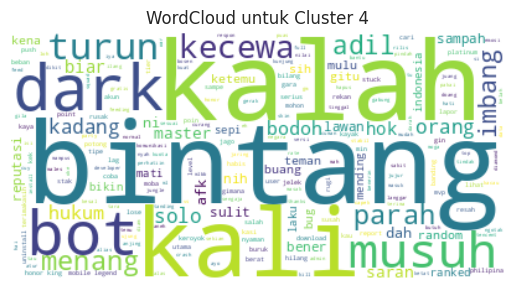


Cluster (KMeans) 0:


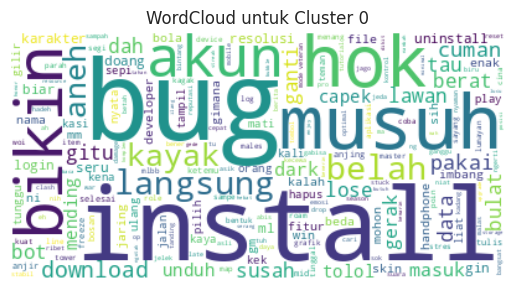


Cluster (KMeans) 5:


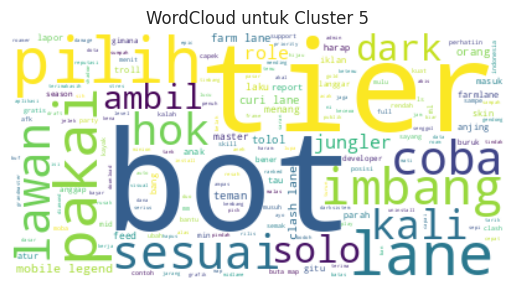


Cluster (KMeans) 1:


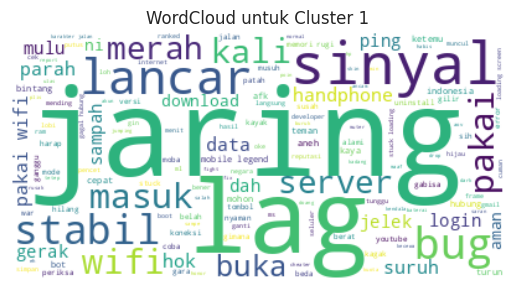


Cluster (KMeans) 3:


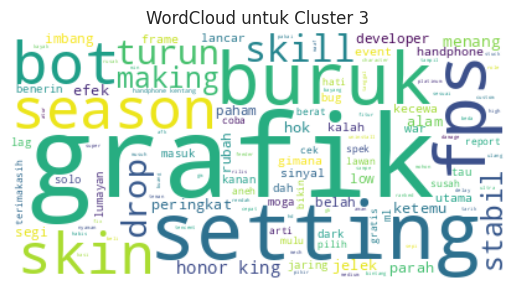


Cluster (KMeans) 2:


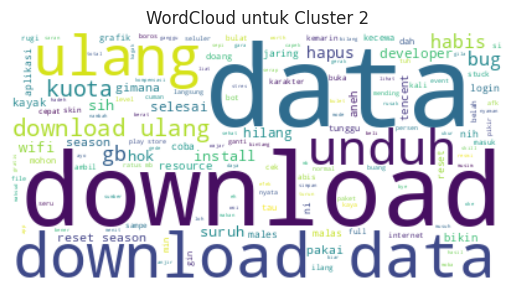

In [ ]:
for cluster in df_neg['Cluster_KMeans'].unique():
    text_data = " ".join(df_neg[df_neg['Cluster_KMeans'] == cluster]['textStemmSTR'])

    wordcloud = WordCloud(
        background_color="white",
        max_words=5000,
        contour_width=3,
        contour_color='steelblue'
    ).generate(text_data)

    print(f"\nCluster (KMeans) {cluster}:")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud untuk Cluster {cluster}")
    plt.show()


Cluster (KMeans) 4:


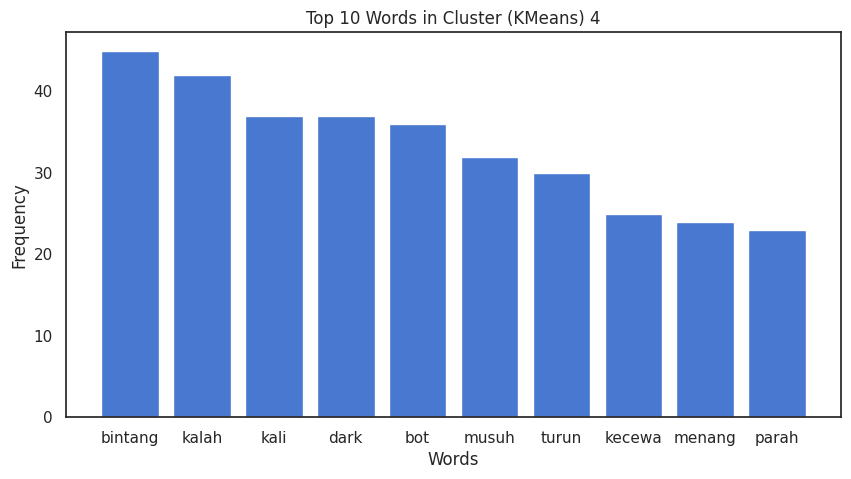


Cluster (KMeans) 0:


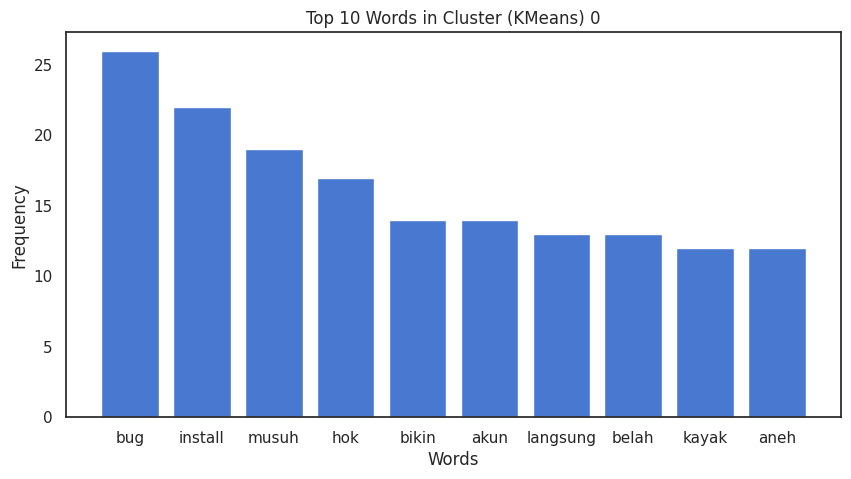


Cluster (KMeans) 5:


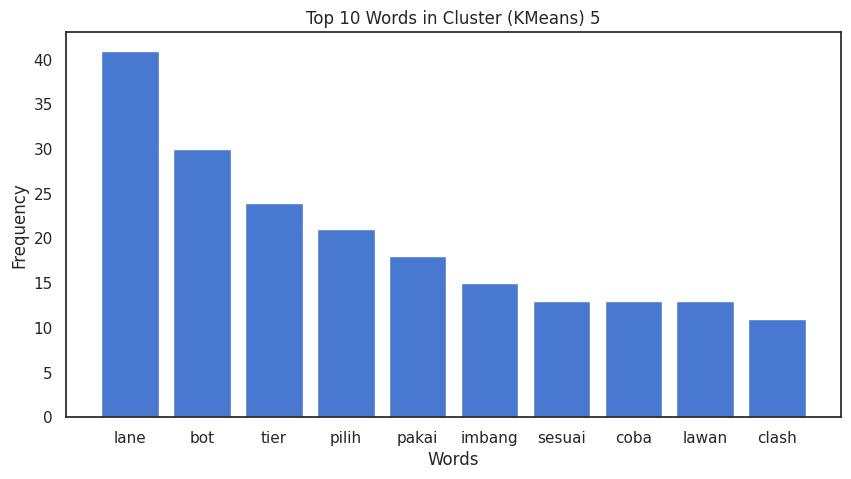


Cluster (KMeans) 1:


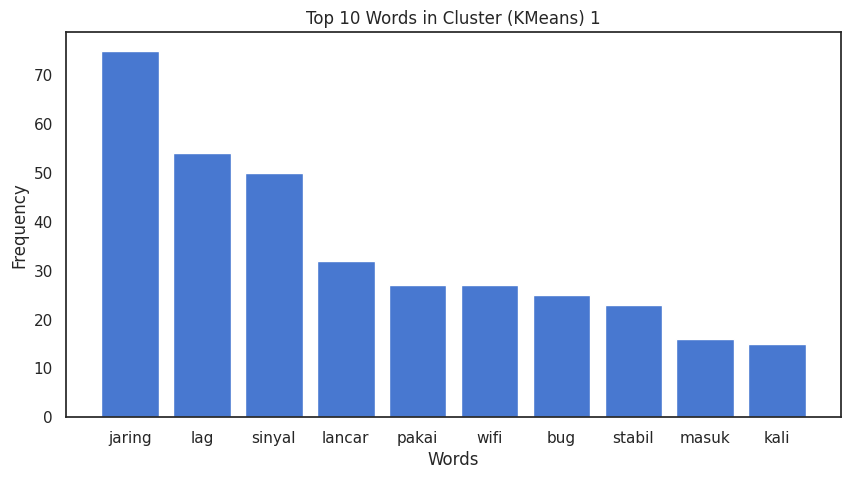


Cluster (KMeans) 3:


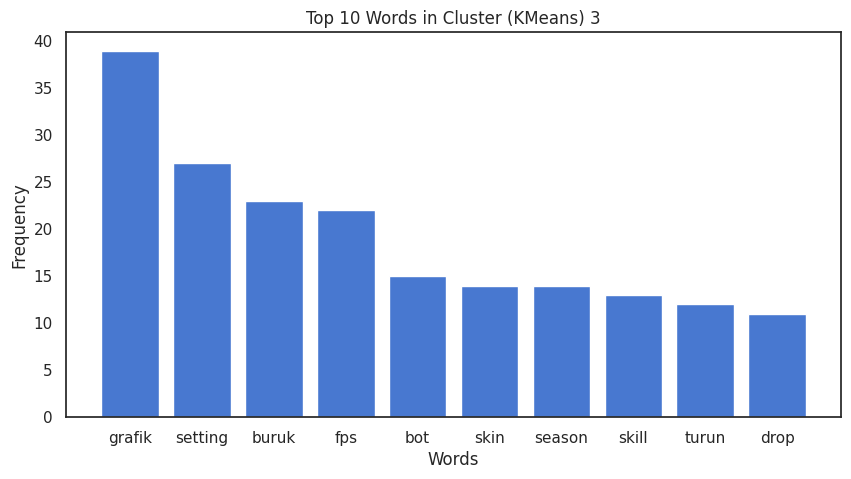


Cluster (KMeans) 2:


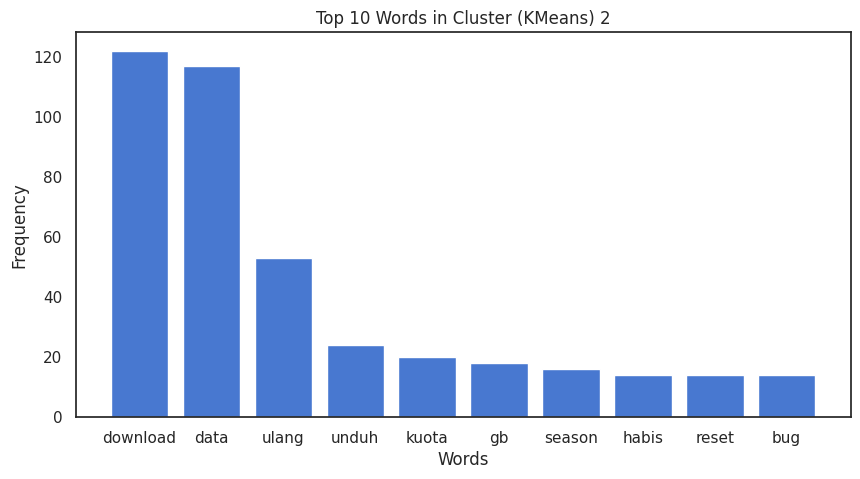

In [ ]:
for cluster in df_neg['Cluster_KMeans'].unique():

    text_data = " ".join(df_neg[df_neg['Cluster_KMeans'] == cluster]['textStemmSTR'])

    top_words = Counter(text_data.split()).most_common(10)

    words, counts = zip(*top_words)

    print(f"\nCluster (KMeans) {cluster}:")
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Words in Cluster (KMeans) {cluster}')
    plt.show()

## Hierarchy

In [ ]:
linkage_methods = ['single', 'complete', 'average', 'ward']

for method in linkage_methods:
  agg_clustering = AgglomerativeClustering(n_clusters=3, linkage=method, metric='euclidean')
  agg_clustering.fit(data_IDF_neg)

  print(f"Cluster Labels for {method} linkage:")
  labels = agg_clustering.labels_
  silhouette_avg = silhouette_score(data_IDF_neg, labels)
  print(f"For {method} linkage:")
  print(f"The average silhouette_score is : {silhouette_avg}")
  print("--------------------------------------------------------------------")

Cluster Labels for single linkage:
For single linkage:
The average silhouette_score is : 0.004587318086725555
--------------------------------------------------------------------
Cluster Labels for complete linkage:
For complete linkage:
The average silhouette_score is : 0.0016770410862943779
--------------------------------------------------------------------
Cluster Labels for average linkage:
For average linkage:
The average silhouette_score is : 0.00418516083493537
--------------------------------------------------------------------
Cluster Labels for ward linkage:
For ward linkage:
The average silhouette_score is : 0.008523808744336973
--------------------------------------------------------------------


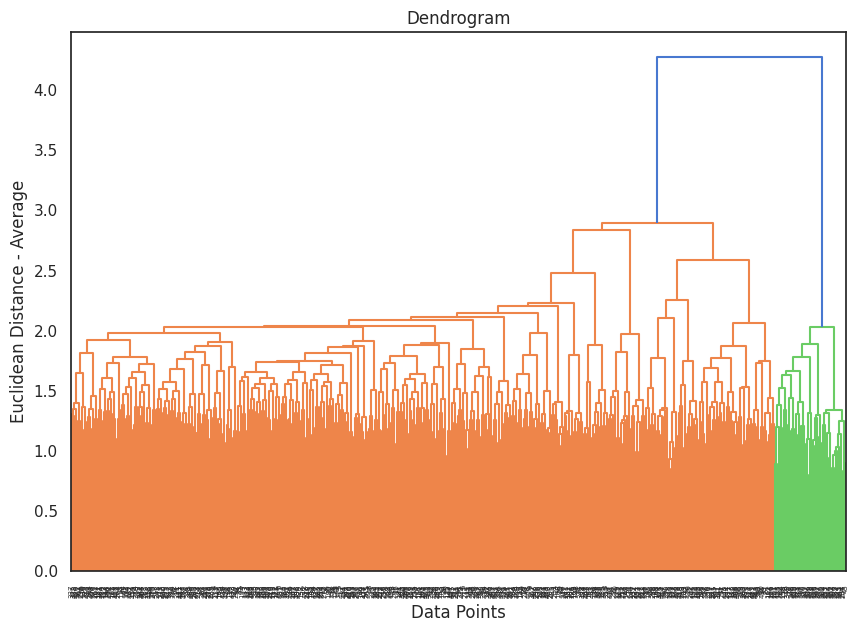

In [ ]:
linked = linkage(data_IDF_neg, method='ward', metric='euclidean')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance - Average')
plt.show()

In [ ]:
num_clusters = 3

clustering = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='ward')
df_neg['Cluster_H_Ward'] = clustering.fit_predict(data_IDF_neg)


Cluster (H_Ward) 0:


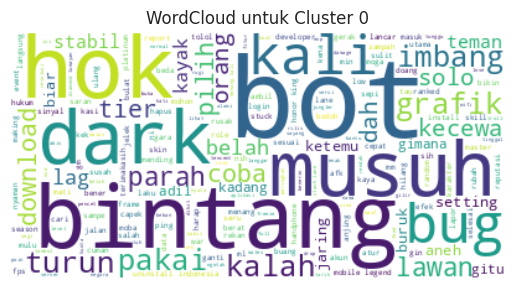


Cluster (H_Ward) 2:


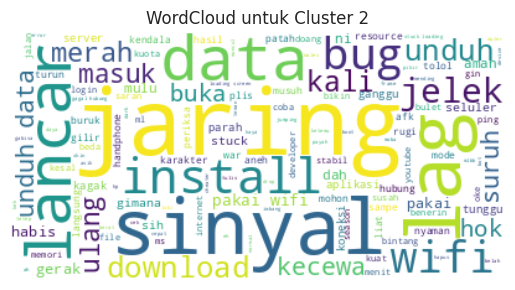


Cluster (H_Ward) 1:


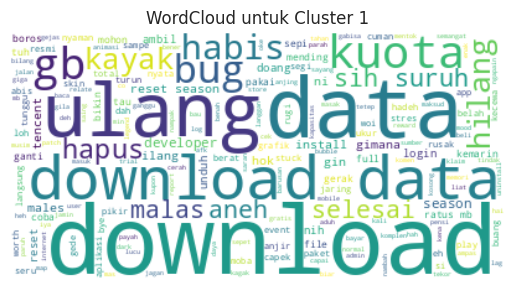

In [ ]:
for cluster in df_neg['Cluster_H_Ward'].unique():
    text_data = " ".join(df_neg[df_neg['Cluster_H_Ward'] == cluster]['textStemmSTR'])

    wordcloud = WordCloud(
        background_color="white",
        max_words=5000,
        contour_width=3,
        contour_color='steelblue'
    ).generate(text_data)

    print(f"\nCluster (H_Ward) {cluster}:")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud untuk Cluster {cluster}")
    plt.show()


Cluster (H_Ward) 0:


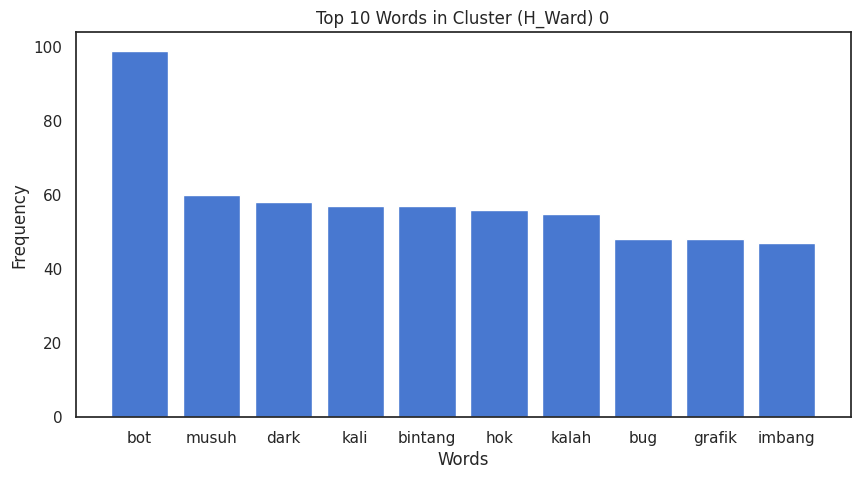


Cluster (H_Ward) 2:


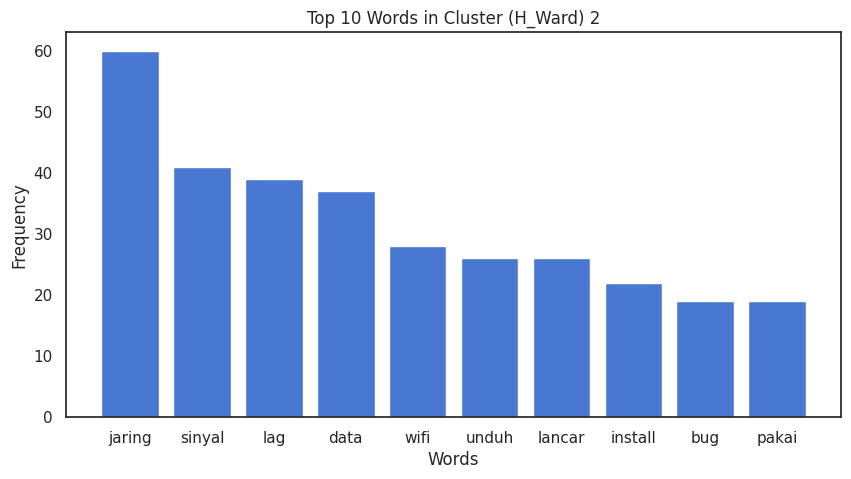


Cluster (H_Ward) 1:


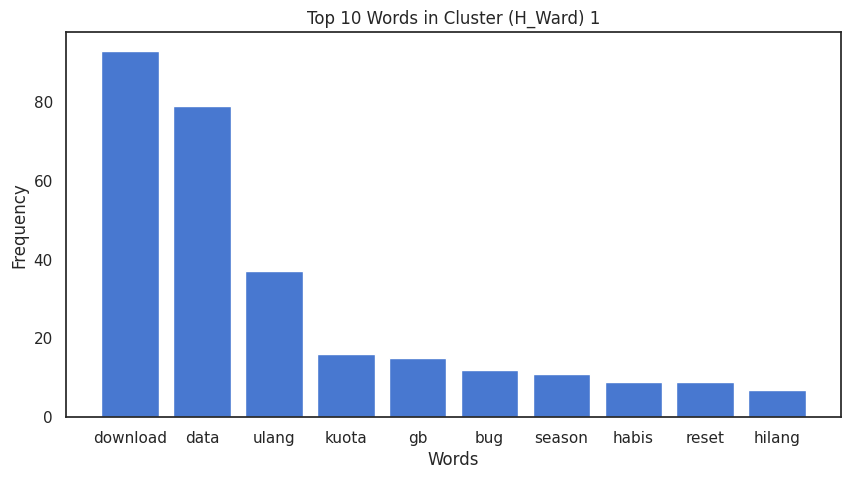

In [ ]:
for cluster in df_neg['Cluster_H_Ward'].unique():

    text_data = " ".join(df_neg[df_neg['Cluster_H_Ward'] == cluster]['textStemmSTR'])

    top_words = Counter(text_data.split()).most_common(10)

    words, counts = zip(*top_words)

    print(f"\nCluster (H_Ward) {cluster}:")
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Words in Cluster (H_Ward) {cluster}')
    plt.show()

## Save to Csv

In [ ]:
df_neg.to_csv('Hasil Clustering HOK.csv', index=False)